In [17]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import models, transforms
import torch
from torchvision import models, transforms
import timm

data_dir = "D:\\Trade-Off_CBIR\\dataset\\Corel-1K"
data_dir_GHIM = "D:\\Trade-Off_CBIR\\dataset\\GHIM-10K"

print("Classes available (Corel-1K):", os.listdir(data_dir))
print("Classes available (GHIM-10K):", os.listdir(data_dir_GHIM))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Classes available (Corel-1K): ['africans', 'beaches', 'buildings', 'buses', 'dinosaurs', 'elephants', 'flowers', 'food', 'horses', 'mountains']
Classes available (GHIM-10K): ['aircraft', 'buildings', 'butterfly', 'cars', 'dragon fly', 'fireworks', 'flowers', 'hen', 'horses', 'insects', 'motorcycles', 'mountains', 'sea shores', 'ships', 'sunset', 'temples', 'trees', 'valleys', 'walls', 'yacht']
Using device: cuda


## Tahap 1: Ekstraksi Fitur

In [18]:
import timm
import torch
from torchvision import models, transforms

# ===============================
# Device
# ===============================
device = "cuda" if torch.cuda.is_available() else "cpu"

# ===============================
# 1. Model Transformer untuk CBIR
# ===============================

# --------- ViT Base 16x16 ---------
vit_baseline = models.vit_b_16(weights=None).to(device).eval()   # Baseline: random init
vit_pretrained = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT).to(device).eval()  # Pretrained

class ViTWithLoRA(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Dummy LoRA / adapter (identity), ganti dengan implementasi nyata jika ada
        self.lora = torch.nn.Identity()

    def forward(self, x):
        x = self.base_model(x)
        x = self.lora(x)
        return x

vit_lora = ViTWithLoRA(vit_pretrained).to(device).eval()  # Pretrained + LoRA

# --------- DeiT Base 16x16 ---------
deit_baseline = timm.create_model('deit_base_patch16_224', pretrained=False).to(device).eval()
deit_pretrained = timm.create_model('deit_base_patch16_224', pretrained=True).to(device).eval()

class DeiTWithLoRA(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.lora = torch.nn.Identity()  # ganti dengan implementasi LoRA nyata

    def forward(self, x):
        x = self.base_model(x)
        x = self.lora(x)
        return x

deit_lora = DeiTWithLoRA(deit_pretrained).to(device).eval()

# --------- Swin Base 224 ---------
swin_baseline = timm.create_model('swin_base_patch4_window7_224', pretrained=False).to(device).eval()
swin_pretrained = timm.create_model('swin_base_patch4_window7_224', pretrained=True).to(device).eval()

class SwinWithLoRA(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.lora = torch.nn.Identity()  # ganti dengan LoRA implementasi nyata

    def forward(self, x):
        x = self.base_model(x)
        x = self.lora(x)
        return x

swin_lora = SwinWithLoRA(swin_pretrained).to(device).eval()

# ===============================
# Transform standar untuk semua model
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ==================================================
# Dictionary semua model Transformer per tipe
# ==================================================
transformer_models = {
    'vit_b16': {
        'baseline': vit_baseline,
        'pretrained': vit_pretrained,
        'lora': vit_lora
    },
    'deit_b16': {
        'baseline': deit_baseline,
        'pretrained': deit_pretrained,
        'lora': deit_lora
    },
    'swin_b': {
        'baseline': swin_baseline,
        'pretrained': swin_pretrained,
        'lora': swin_lora
    }
}


## Tahap 2: Pre-trained Models

In [19]:
import time
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch
import torch.nn.functional as F

# ===============================
# Fungsi ekstraksi fitur
# ===============================
def extract_features(model, img_tensor, model_name=None, model_type=None):
    """
    Ambil embedding sebelum classifier, flatten, L2-normalize.
    model_name: str, contoh 'vit_b16', 'deit_b16', 'swin_b'
    model_type: str, contoh 'baseline', 'pretrained', 'lora'
    """
    model.eval()
    with torch.no_grad():
        # Transformer models dengan forward_features
        if hasattr(model, 'forward_features'):
            feat = model.forward_features(img_tensor)
        else:
            feat = model(img_tensor)
        
        # Jika output 4D (batch, channels, H, W)
        if feat.dim() == 4:
            feat = F.adaptive_avg_pool2d(feat, 1)
            feat = torch.flatten(feat, 1)
        else:
            feat = feat.flatten(start_dim=1)
        
        # L2-normalisasi
        feat = F.normalize(feat, p=2, dim=1)
    
    return feat.cpu().numpy()


# ===============================
# Ukur inference speed
# ===============================
def measure_inference_speed(model, sample_img, transform, device='cuda', model_name=None, model_type=None):
    """
    Ukur waktu inference untuk satu gambar.
    """
    img_t = transform(sample_img).unsqueeze(0).to(device)
    if device=='cuda':
        torch.cuda.synchronize()
    start = time.time()
    _ = extract_features(model, img_t, model_name=model_name, model_type=model_type)
    if device=='cuda':
        torch.cuda.synchronize()
    end = time.time()
    return end - start


# ===============================
# Ukur embedding metrics (inter/intra-class similarity)
# ===============================
def measure_embedding_metrics(features, labels):
    """
    features: np.array, shape=(N, D)
    labels: list/array, class label per fitur
    """
    sims = cosine_similarity(features, features)
    search_time = 0  # optional: bisa ukur waktu jika mau
    
    classes = sorted(list(set(labels)))

    # Inter-class similarity
    inter_dists = []
    for i, cls_i in enumerate(classes):
        idx_i = [k for k,l in enumerate(labels) if l==cls_i]
        for j, cls_j in enumerate(classes):
            if i >= j:
                continue
            idx_j = [k for k,l in enumerate(labels) if l==cls_j]
            inter_dists.append(np.mean(sims[np.ix_(idx_i, idx_j)]))
    
    # Intra-class similarity
    intra_dists = []
    for cls in classes:
        idx = [k for k,l in enumerate(labels) if l==cls]
        intra_dists.append(np.mean(sims[np.ix_(idx, idx)]))
    
    return search_time, np.mean(inter_dists), np.mean(intra_dists)


# ===============================
# Fungsi bantu evaluasi semua model x tipe
# ===============================
def evaluate_all_transformers(transformer_models, features_dict, labels, sample_img=None, transform=None, device='cuda'):
    """
    transformer_models: dict[model_name][model_type] -> model
    features_dict: dict[model_name][model_type] -> np.array fitur
    labels: list label dataset
    sample_img: PIL.Image untuk inference speed
    transform: transform image
    """
    results = {}
    for model_name, model_types in transformer_models.items():
        results[model_name] = {}
        for t_type, model in model_types.items():
            feats = features_dict[model_name][t_type]
            
            # Inference speed (jika sample_img diberikan)
            if sample_img is not None and transform is not None:
                speed = measure_inference_speed(model, sample_img, transform, device, model_name, t_type)
            else:
                speed = None
            
            # Embedding metrics
            search_time, inter_class, intra_class = measure_embedding_metrics(feats, labels)
            
            results[model_name][t_type] = {
                'inference_speed': speed,
                'search_time': search_time,
                'inter_class_sim': inter_class,
                'intra_class_sim': intra_class
            }
    return results


In [ ]:
from tqdm import tqdm
import torch
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import normalize
import torch.nn.functional as F

# --------------------------
# List semua file dan label
# --------------------------
img_paths = []
labels = []

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    for f in os.listdir(cls_path):
        img_paths.append(os.path.join(cls_path, f))
        labels.append(cls)

# --------------------------
# Fungsi ekstraksi fitur
# --------------------------
def extract_features(model, img_tensor, model_name=None, model_type=None):
    """
    Ambil embedding sebelum classifier, flatten, L2-normalize
    model_name: 'vit_b16', 'deit_b16', 'swin_b'
    model_type: 'baseline', 'pretrained', 'lora'
    """
    model.eval()
    with torch.no_grad():
        if hasattr(model, 'forward_features'):
            feat = model.forward_features(img_tensor)
        else:
            feat = model(img_tensor)

        # Jika output 4D (batch, channels, H, W)
        if feat.dim() == 4:
            feat = F.adaptive_avg_pool2d(feat, 1)
            feat = torch.flatten(feat, 1)
        else:
            feat = feat.flatten(start_dim=1)

        # L2-normalisasi
        feat = F.normalize(feat, p=2, dim=1)

    return feat.cpu().numpy()


# --------------------------
# Ekstraksi fitur untuk semua model × tipe
# --------------------------
# Dictionary: model_name -> tipe -> list fitur
features_dict = {m: {t: [] for t in transformer_models[m].keys()} for m in transformer_models}

for path in tqdm(img_paths, desc="Extracting Transformer Features"):
    img = Image.open(path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device) # pyright: ignore[reportAttributeAccessIssue]

    for model_name, model_types in transformer_models.items():  # vit_b16, deit_b16, swin_b
        for t_type, model in model_types.items():  # baseline, pretrained, lora
            feat = extract_features(model, img_t, model_name=model_name, model_type=t_type).squeeze()
            features_dict[model_name][t_type].append(feat)

# --------------------------
# Convert ke numpy array & normalisasi
# --------------------------
for model_name, model_types in features_dict.items():
    for t_type, feats in model_types.items():
        features_dict[model_name][t_type] = normalize(np.array(feats))  # pyright: ignore[reportArgumentType]


Extracting Transformer Features:  34%|███▍      | 338/1000 [14:49<29:48,  2.70s/it]

## Tahap 3: Image Retrieval & Similarity Matching

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# --------------------------
# Fungsi retrieve top-K berdasarkan cosine similarity
# --------------------------
def retrieve(query_feat, all_feats, top_k=10):
    sims = cosine_similarity([query_feat], all_feats)[0]  # pyright: ignore[reportArgumentType]
    idxs = np.argsort(sims)[::-1][:top_k]
    return idxs

# --------------------------
# Fungsi evaluasi Recall@K & Precision@K per kelas
# --------------------------
def evaluate_recall_precision(features, labels, top_k=10, model_type=None):
    """
    features: numpy array, shape = (N, dim_feature)
    labels: list of length N
    top_k: int
    model_type: optional, string untuk logging
    """
    classes = sorted(list(set(labels)))
    results = []

    for cls in classes:
        idxs_cls = [i for i, l in enumerate(labels) if l == cls]
        R_list, P_list = [], []

        for q in idxs_cls:
            retrieved_idx = retrieve(features[q], features, top_k)
            retrieved_labels = [labels[i] for i in retrieved_idx]

            R = retrieved_labels.count(cls) / len(idxs_cls)
            P = retrieved_labels.count(cls) / top_k

            R_list.append(R)
            P_list.append(P)

        results.append([cls, np.mean(R_list), np.mean(P_list)])

    df = pd.DataFrame(results, columns=['Class','R','P'])

    # Tambahkan row Mean keseluruhan
    mean_row = {'Class': 'Mean', 'R': df['R'].mean(), 'P': df['P'].mean()}
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    # Format angka 4 desimal
    df['R'] = df['R'].astype(float).map("{:.4f}".format)
    df['P'] = df['P'].astype(float).map("{:.4f}".format)

    if model_type is not None:
        print(f"[{model_type}] Recall@{top_k} / Precision@{top_k} selesai")
    return df


# --------------------------
# Evaluasi untuk semua model × tipe
# --------------------------
# features_dict sudah ada: model_name -> tipe -> features
eval_results = {}

for m_name, m_types in features_dict.items():  # vit_b16, deit_b16, swin_b
    eval_results[m_name] = {}
    for t_type, feats in m_types.items():       # baseline, pretrained, lora
        df = evaluate_recall_precision(feats, labels, top_k=10, model_type=f"{m_name}-{t_type}")
        eval_results[m_name][t_type] = df

# Contoh akses hasil:
# eval_results['vit_b16']['pretrained']
# eval_results['deit_b16']['lora']


## Tahap 4: Evaluasi

In [ ]:
from PIL import Image
import pandas as pd

# --------------------------
# Ambil sample image untuk inference speed
# --------------------------
sample_img = Image.open(img_paths[0]).convert('RGB')

# --------------------------
# Inisialisasi list untuk DataFrame
# --------------------------
rows = []

# --------------------------
# Ukur inference speed & embedding metrics untuk semua model × tipe
# --------------------------
for m_name, m_types in transformer_models.items():  # vit_b16, deit_b16, swin_b
    for t_type, model in m_types.items():           # baseline, pretrained, lora
        # Inference speed
        inf_time = measure_inference_speed(model, sample_img, transform, device=str(device),
                                           model_name=m_name, model_type=t_type)
        # Embedding metrics
        feats = features_dict[m_name][t_type]
        search_time, inter_dist, intra_dist = measure_embedding_metrics(feats, labels)

        # Simpan hasil
        rows.append({
            'Model': f"{m_name}-{t_type}",
            'Inference speed (s/img)': inf_time,
            'Embedding search time (s)': search_time,
            'Inter-class dist': inter_dist,
            'Intra-class dist': intra_dist
        })

# --------------------------
# Buat DataFrame & tampilkan
# --------------------------
df_metrics = pd.DataFrame(rows)
display(df_metrics)


,Model,Inference speed (s/img),Embedding search time (s),Inter-class dist,Intra-class dist
0,ViT-B16,0.284589,0.030580,0.018716,0.511832
1,DeiT-B16,0.039347,1.505292,0.080617,0.273018
2,Swin-B,0.035653,0.001010,0.611779,0.756531


In [ ]:
import pandas as pd

# --------------------------
# Membuat tabel per kelas untuk semua model × tipe
# --------------------------
classes = sorted(list(set(labels)))
df_table = pd.DataFrame({'Class': classes})

# Loop untuk setiap model × tipe
for m_name, m_types in features_dict.items():  # vit_b16, deit_b16, swin_b
    for t_type, feats in m_types.items():      # baseline, pretrained, lora
        df_eval = evaluate_recall_precision(feats, labels)
        col_r = f"{m_name}-{t_type} R"
        col_p = f"{m_name}-{t_type} P"
        df_table[col_r] = df_eval['R'].astype(float)
        df_table[col_p] = df_eval['P'].astype(float)

# --------------------------
# Tambahkan row Mean per kolom
# --------------------------
mean_row = {'Class': 'Mean'}
for col in df_table.columns[1:]:
    mean_row[col] = df_table[col].mean()
df_table = pd.concat([df_table, pd.DataFrame([mean_row])], ignore_index=True)

# --------------------------
# Format angka 4 desimal
# --------------------------
for col in df_table.columns[1:]:
    df_table[col] = df_table[col].map("{:.4f}".format)

# --------------------------
# Tampilkan tabel
# --------------------------
display(df_table)


,Class,ViT-B16 R,ViT-B16 P,DeiT-B16 R,DeiT-B16 P,Swin-B R,Swin-B P
0,africans,0.0938,0.9380,0.0895,0.8950,0.0283,0.2830
1,beaches,0.0979,0.9790,0.0974,0.9740,0.0232,0.2320
2,buildings,0.0966,0.9660,0.0951,0.9510,0.0245,0.2450
3,buses,0.1000,1.0000,0.1000,1.0000,0.0433,0.4330
4,dinosaurs,0.1000,1.0000,0.1000,1.0000,0.0477,0.4770
5,elephants,0.1000,1.0000,0.1000,1.0000,0.0434,0.4340
6,flowers,0.1000,1.0000,0.1000,1.0000,0.0435,0.4350
7,food,0.0992,0.9920,0.0964,0.9640,0.0541,0.5410
8,horses,0.1000,1.0000,0.1000,1.0000,0.0307,0.3070
9,mountains,0.0995,0.9950,0.0998,0.9980,0.0283,0.2830


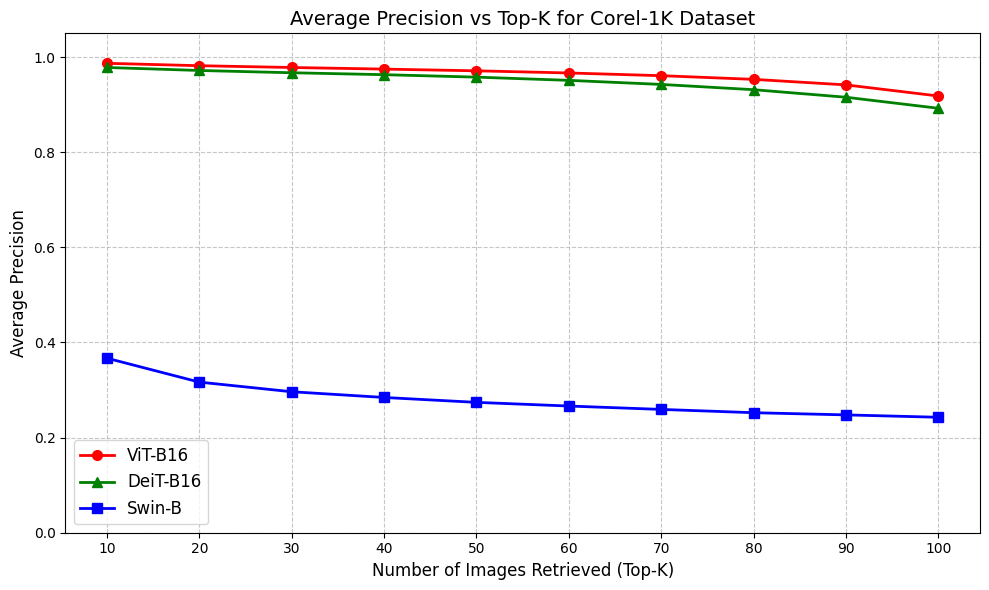

In [ ]:
import matplotlib.pyplot as plt

def average_precision_vs_topk(features_dict, labels, top_k_max=100):
    """
    features_dict: dict -> model_name -> tipe -> features
    labels: list of class labels
    top_k_max: maksimum top-K
    """
    top_ks = list(range(10, top_k_max + 1, 10))
    avg_prec = {}

    # Hitung Average Precision untuk setiap model × tipe
    for m_name, m_types in features_dict.items():
        for t_type, feats in m_types.items():
            key = f"{m_name}-{t_type}"
            avg_prec[key] = []
            for top_k in top_ks:
                df = evaluate_recall_precision(feats, labels, top_k=top_k)
                df['P'] = df['P'].astype(float)
                avg_prec[key].append(df['P'].mean())

    plt.figure(figsize=(12, 6))

    # Marker dan warna bisa disesuaikan per tipe / model
    markers = ['o', '^', 's', 'D', 'v', '*', 'x']
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']

    for idx, key in enumerate(avg_prec):
        plt.plot(top_ks, avg_prec[key],
                 marker=markers[idx % len(markers)],
                 color=colors[idx % len(colors)],
                 linestyle='-',
                 linewidth=2,
                 markersize=6,
                 label=key)

    plt.xlabel("Number of Images Retrieved (Top-K)", fontsize=12)
    plt.ylabel("Average Precision", fontsize=12)
    plt.title("Average Precision vs Top-K for Transformer Models (All Types)", fontsize=14)
    plt.xticks(top_ks)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10, ncol=2)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# --------------------------
# Jalankan evaluasi dan plot
# --------------------------
average_precision_vs_topk(features_dict, labels, top_k_max=100)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def show_topk_cbir(features, labels, img_paths, top_k=4, model_name="Model", query_idx=None):
    """
    Menampilkan query image + top-K retrieved images dengan bounding box:
    - Biru untuk query
    - Hijau jika label sama (benar), merah jika salah

    features: np.array, shape=(N, D)
    labels: list of length N
    img_paths: list of image paths
    model_name: str, nama model untuk judul plot
    query_idx: int, index query image. Jika None, pilih random.
    """
    if query_idx is None:
        import random
        query_idx = random.randint(0, len(labels) - 1)
    
    cls = labels[query_idx]

    # Retrieve top-K
    retrieved_idx = retrieve(features[query_idx], features, top_k)

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{model_name} - Query Class: {cls}", fontsize=14)

    # Query image
    query_img = Image.open(img_paths[query_idx]).convert('RGB')
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query", fontsize=10)
    plt.gca().add_patch(patches.Rectangle(
        (0, 0), query_img.width, query_img.height,
        edgecolor='blue', fill=False, linewidth=3)
    )

    # Retrieved images
    for i, idx in enumerate(retrieved_idx):
        img = Image.open(img_paths[idx]).convert('RGB')
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(img)
        plt.axis('off')
        color = 'green' if labels[idx] == cls else 'red'
        plt.gca().add_patch(patches.Rectangle(
            (0, 0), img.width, img.height,
            edgecolor=color, fill=False, linewidth=3)
        )
        plt.title(labels[idx], fontsize=9)

    plt.tight_layout()
    plt.show()


In [ ]:
import random

for m_name, m_types in features_dict.items():
    for t_name, feats in m_types.items():
        model_label = f"{m_name}-{t_name}"
        
        # Pilih satu query random
        query_idx = random.randint(0, len(labels) - 1)
        
        # Tampilkan Top-K CBIR
        show_topk_cbir(
            features=feats,
            labels=labels,
            img_paths=img_paths,
            top_k=4,
            model_name=model_label,
            query_idx=query_idx
        )
